In [ ]:
Projeyi geç başladığım ve makine öğrenmesine dair yaptığım ilk proje olmasından kaynaklı bitiremedim ama çok uğraştım o nedenle oluğu haliyle göndermek istedim.
Çok keyifli bir süreçti. Teşekkürler :)

****US-Accident dataset contains datas of accidents that collected from 2016 to 2023 from 49 states of the USA. I will try to train a madel that can predict severity of accidents.In this way, the model can measure the severity of a new accident and it can inform authorities.
Firstly, I should analyze dataset and decide how can I process data. The dataset currently contains approximately 7.7 million accident records and it contains very detailed informations but, I don't need to use all of them. ****

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import joblib


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-accidents/US_Accidents_March23.csv


In [2]:
df = pd.read_csv('/kaggle/input/us-accidents/US_Accidents_March23.csv')



In [ ]:
df.head()

**The dataset is very large and hard to process so, I will work on only small sample**

In [6]:
df_sample = df.sample(frac=0.1, random_state=42)


In [7]:
data_check = df_sample['Severity'].value_counts()
print(data_check)

Severity
2    615250
3    130256
4     20530
1      6803
Name: count, dtype: int64


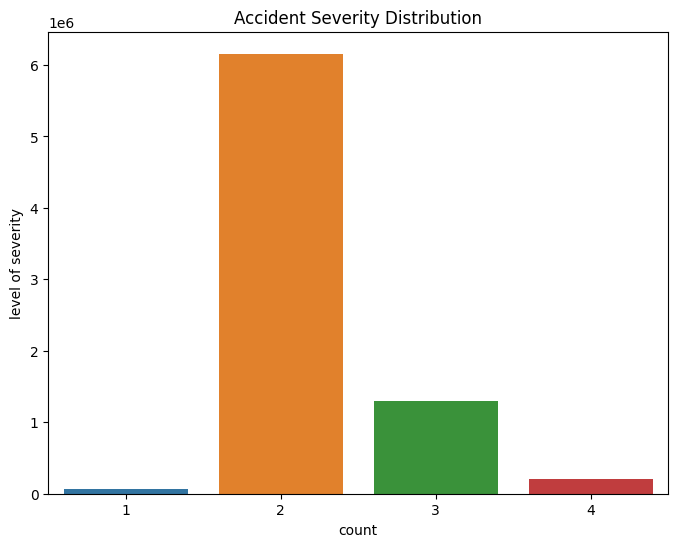

In [8]:

plt.figure(figsize=(8,6))
sns.countplot(x='Severity', data=df)
plt.title('Accident Severity Distribution')
plt.xlabel('count')
plt.ylabel('level of severity')
plt.show()


**Seeing how the data is distributed both numerically and visually helps to better understand and process the data. As we can see this data set is unbalanced. I will handle this unbalanced dataset by using SMOTE later.**

In [9]:
from sklearn.model_selection import train_test_split
# we will use severity column as the target variable so we should separate severity column and predictor variables
y = df_sample['Severity'] # target value
x = df_sample.drop(['Severity'], axis=1) # predictor values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)# I used %20 test size as convention


**Now, data splitting is occured as %20 of data is test set that we can evalute the model's performance and %80 of data is training set that we can train our model.***

In [10]:
print(x.isnull().sum())

ID                            0
Source                        0
Start_Time                    0
End_Time                      0
Start_Lat                     0
Start_Lng                     0
End_Lat                  340548
End_Lng                  340548
Distance(mi)                  0
Description                   1
Street                     1088
City                         28
County                        0
State                         0
Zipcode                     180
Country                       0
Timezone                    757
Airport_Code               2226
Weather_Timestamp         12037
Temperature(F)            16385
Wind_Chill(F)            200024
Humidity(%)               17400
Pressure(in)              14092
Visibility(mi)            17673
Wind_Direction            17603
Wind_Speed(mph)           57485
Precipitation(in)        220612
Weather_Condition         17301
Amenity                       0
Bump                          0
Crossing                      0
Give_Way

****There are many NaN values and nearly all of them are unneccessary to predict severity of accidents. I think only City and Street values are important for the model, they should not be dropped but I have no time and the training method takes a long time to run so, I will drop all NaN values.  ****

In [11]:

columns_to_drop = [col for col in x.columns if x[col].isnull().mean() ]
print(" columns to drop:", columns_to_drop)
x = x.drop(columns=columns_to_drop)


 columns to drop: ['End_Lat', 'End_Lng', 'Description', 'Street', 'City', 'Zipcode', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


In [12]:
cat_columns = x.select_dtypes(include=['object', 'category']).columns.tolist()
num_columns = x.select_dtypes(include=['int64', 'float64']).columns.tolist()

 categorical and numeric variables should be separated and then I will do One-Hot encoding for categorical variables, 

In [13]:
from sklearn.impute import SimpleImputer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(),num_columns), # StandartScaler() is used for numeric values' scaling and normalization.
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns) # if there are unknown values, they will be 0.
    ]
)

**ImbPipeline is used because of unbalanced data set. This pipeline is able to handling unbalanced values.**

In [15]:
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),# for handling unbalanced distribution
    ('classifier', RandomForestClassifier(random_state=42))
])


In [ ]:
pipeline.fit(X_train, y_train)